In [1]:
using Pkg
pkg"activate ."

In [2]:
using PerlaTonettiWaugh, Plots, BenchmarkTools

In [3]:
gr(fmt = :png)

Plots.GRBackend()

# Steady states

## Solving steady state solutions

Set up parameters and find the corresponding stationary solution:

In [4]:
# Define common objects. 
parameters = parameter_defaults()

settings = settings_defaults()
settings = merge(settings, (transition_penalty_coefficient = 1.0, ))
z_grid = settings.z
M = length(z_grid)

d_0 = parameters.d_0
d_T = parameters.d_T
params_0 = merge(parameters, (d = d_0,)) # parameters to be used at t = 0
params_T = merge(parameters, (d = d_T,)) # parameters to be used at t = T

# solve for stationary solution at t = 0
stationary_sol_0 = stationary_numerical(params_0, z_grid) # solution at t = 0
stationary_sol = stationary_numerical(params_T, z_grid) # solution at t = T

Ω_0 = stationary_sol_0.Ω;
Ω_T = stationary_sol.Ω;

## Welfare in steady states

### Steady state at `T`

In [5]:
display_stationary_sol(stationary_sol);

g = 0.020615710253102364
z_hat = 1.4039337090190345
Ω = 1.2562899003237646
y = 1.3124933028572352
c = 1.3124933028572352
U_bar = getfield(PerlaTonettiWaugh, Symbol("##21#22")){Float64,Float64,Float64,Float64}(0.020615710253102364, 0.02, 1.0, 1.3124933028572352)
λ_ii = 0.7552342507090134
L_tilde = 0.2099540490178484
z_bar = 1.661287297562375
w = 0.41640447602826725
x = 1.0
π_min = 0.057942557180211345
r = 0.09361571025310236
a = 9.160936798927867
b = 0.1424454938003916
S = 0.03389742154659973


### Steady state at `0`

In [6]:
display_stationary_sol(stationary_sol_0);

g = 0.010930652403331097
z_hat = 1.813536131626652
Ω = 1.7797899977898557
y = 1.4215794009183362
c = 1.4215794009183362
U_bar = getfield(PerlaTonettiWaugh, Symbol("##21#22")){Float64,Float64,Float64,Float64}(0.010930652403331097, 0.02, 1.0, 1.4215794009183362)
λ_ii = 0.8982453618545706
L_tilde = 0.19292029410354766
z_bar = 1.7613866270362195
w = 0.44149454256973625
x = 1.0
π_min = 0.04969310649379504
r = 0.0839306524033311
a = 12.468098351241073
b = 0.1490608571684243
S = -0.011680460694423862


# Transition dynamics

Setup for optimizer:

In [7]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_sol, Ω_0 = Ω_0));

Find the corresponding solution (should take about 100s to run)

In [8]:
@time result = solve_full_model_nlopt(settings; impose_E_monotonicity_constraints = true)
solved = result.solution;
E_nodes = result.E_nodes;

114.111809 seconds (233.98 M allocations: 112.497 GiB, 10.35% gc time)


In [9]:
println("E_nodes (sorted) : ")
sort(E_nodes)

E_nodes (sorted) : 


14-element Array{Float64,1}:
 -0.9292177397159866 
 -0.7943649969667788 
 -0.6074874641357887 
 -0.49189979684672824
 -0.3347176170032159 
 -0.24481769383592616
 -0.24481769383592616
 -0.12833092365907556
 -0.08936576264703058
 -0.07942433422192792
 -0.05398997533585611
 -0.041889325410586  
 -0.02836357671136145
 -0.02836357671136145

## Plots for Ω and residuals

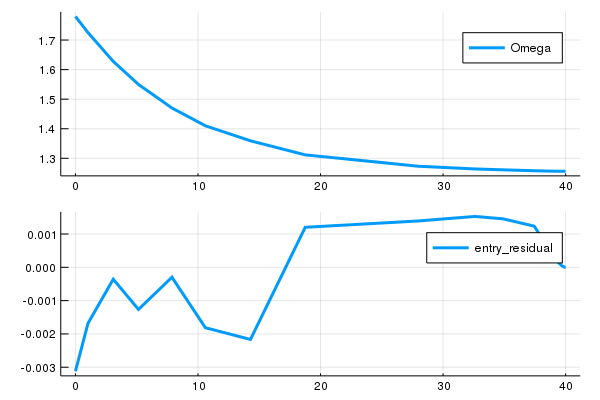

In [10]:
solved = solved.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

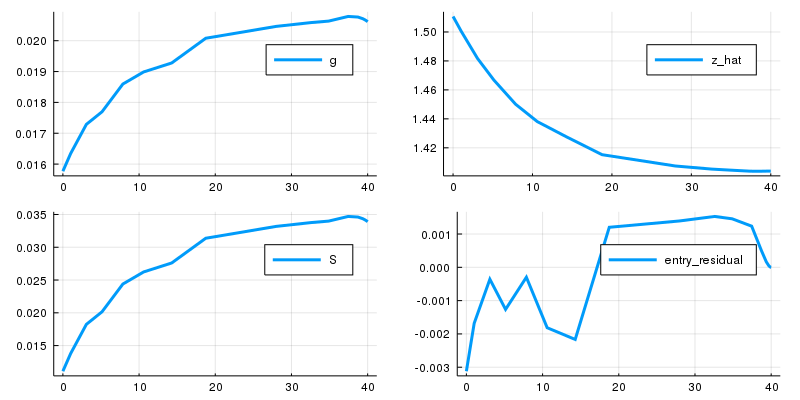

In [11]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2), size = (800, 400))

## Static Equations

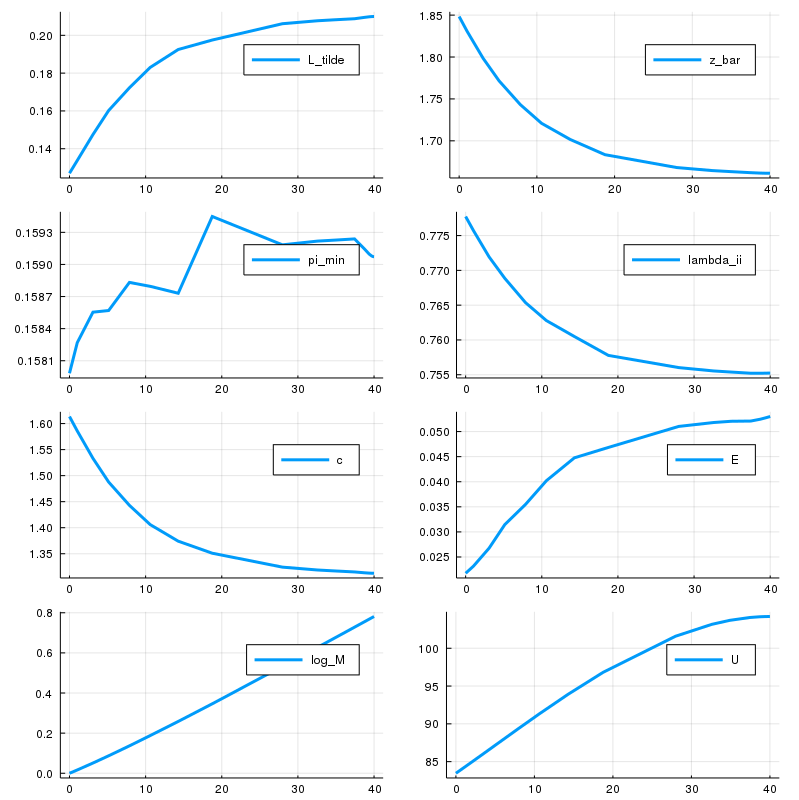

In [12]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2), size = (800, 800))

# Welfare analysis

### `log_M(t)`

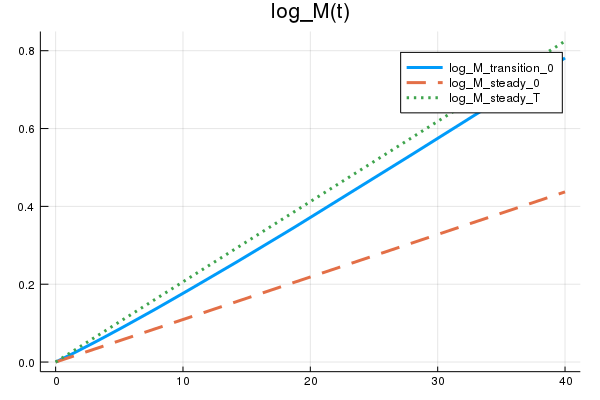

In [13]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### `Ω(t)`

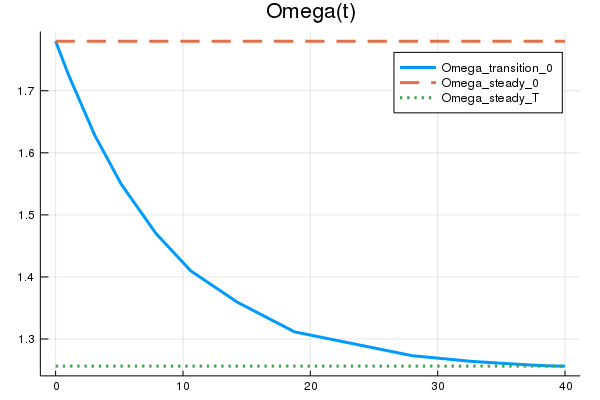

In [14]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### `c(t)`

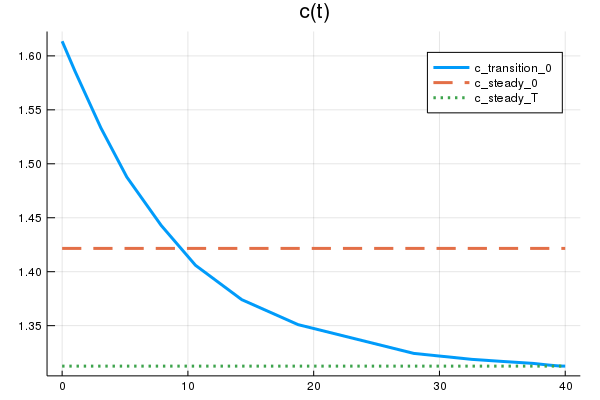

In [15]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

### `U(t)`

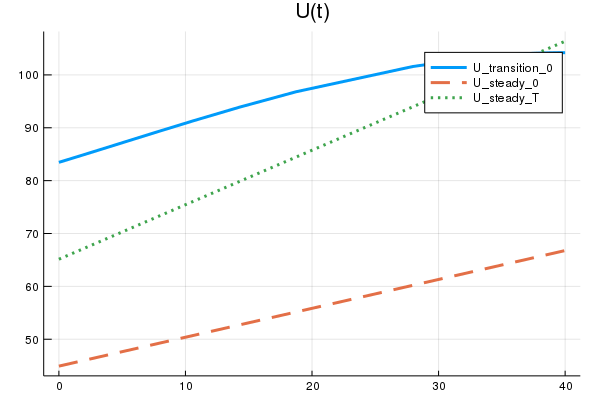

In [16]:
# generate the plot!
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

## Consumption equivalent for search threshold (`M(0)`)
See computational appendix for details.

### `M(0)` by two steady states (autarky and steady state at `T`)

In [17]:
T = solved.t[end]
consumption_equivalent(solved.U[end], stationary_sol_0.U_bar(T), parameters)

2.113814700402491

### `M(0)` by autarky and transition from `t=0`

In [18]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(T), parameters)

1.3961620025279196

### Running with 50 Nodes

In [19]:
# Define common objects. 
parameters = parameter_defaults()

settings = settings_defaults()
settings = merge(settings, (transition_penalty_coefficient = 1.0, ))
z_grid = settings.z
M = length(z_grid)

d_0 = parameters.d_0
d_T = parameters.d_T
params_0 = merge(parameters, (d = d_0,)) # parameters to be used at t = 0
params_T = merge(parameters, (d = d_T,)) # parameters to be used at t = T

# solve for stationary solution at t = 0
stationary_sol_0 = stationary_numerical(params_0, z_grid) # solution at t = 0
stationary_sol = stationary_numerical(params_T, z_grid) # solution at t = T

Ω_0 = stationary_sol_0.Ω;
Ω_T = stationary_sol.Ω;

settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_sol, Ω_0 = Ω_0, transition_x0 = settings.fifty_node_iv, E_node_counts = 50));

In [20]:
@time result = solve_full_model_nlopt(settings; impose_E_monotonicity_constraints = true)
solved = result.solution;
E_nodes = result.E_nodes;

299.155284 seconds (606.94 M allocations: 577.994 GiB, 16.30% gc time)


In [21]:
print(E_nodes)

[-1.00157, -0.848157, -0.821211, -0.821211, -0.821211, -0.748497, -0.633587, -0.527711, -0.498239, -0.498239, -0.498239, -0.498239, -0.3316, -0.3316, -0.3316, -0.3316, -0.3316, -0.281318, -0.281318, -0.281318, -0.281318, -0.281318, -0.241756, -0.230492, -0.168434, -0.168434, -0.168434, -0.168434, -0.105236, -0.103655, -0.103655, -0.0787871, -0.0787871, -0.0787871, -0.0787871, -0.0787871, -0.0787871, -0.0713765, -0.0713765, -0.0713765, -0.0713765, -0.0343871, -0.0334064, -0.0334064, -0.029373, -0.029373, -0.029373, -0.029373, -0.029373, -0.029373]

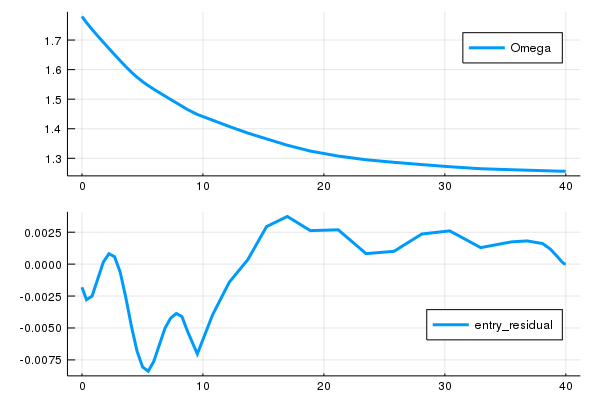

In [22]:
solved = solved.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3, legend = :bottomright)
plot(plot_Ω, plot_residual, layout = (2,1))

In [25]:
using Interpolations

In [28]:
# Define common objects. 
parameters = parameter_defaults()

settings = settings_defaults()
settings = merge(settings, (transition_penalty_coefficient = 1.0, ))
z_grid = settings.z
M = length(z_grid)

d_0 = parameters.d_0
d_T = parameters.d_T
params_0 = merge(parameters, (d = d_0,)) # parameters to be used at t = 0
params_T = merge(parameters, (d = d_T,)) # parameters to be used at t = T

# solve for stationary solution at t = 0
stationary_sol_0 = stationary_numerical(params_0, z_grid) # solution at t = 0
stationary_sol = stationary_numerical(params_T, z_grid) # solution at t = T

Ω_0 = stationary_sol_0.Ω;
Ω_T = stationary_sol.Ω;

# create the 50-node interp
interp = LinearInterpolation(1:14, settings.transition_x0)

14-element extrapolate(scale(interpolate(::Array{Float64,1}, BSpline(Linear())), (1:14,)), Throw()) with element type Float64:
 -0.9292177397159866 
 -0.7943649969667788 
 -0.6074874641357887 
 -0.49189979684672824
 -0.3347176170032159 
 -0.24481769383592616
 -0.24481769383592616
 -0.12833092365907556
 -0.08936576264703058
 -0.07942433422192792
 -0.05398997533585611
 -0.041889325410586  
 -0.02836357671136145
 -0.02836357671136145

In [42]:
points = interp.(range(1, 14.0, length = 50))

50-element Array{Float64,1}:
 -0.9292177397159866  
 -0.8934404814355845  
 -0.8576632231551824  
 -0.8218859648747804  
 -0.7829235153648815  
 -0.7333437617566596  
 -0.6837640081484377  
 -0.6341842545402158  
 -0.5933338722228425  
 -0.562667756411459   
 -0.5320016406000758  
 -0.5013355247886924  
 -0.46302960054894027 
  ⋮                   
 -0.05300216717869122 
 -0.04979179066790527 
 -0.04658141415711932 
 -0.04337103764633336 
 -0.03995707559641107 
 -0.03636861165580048 
 -0.032780147715189875
 -0.029191683774579286
 -0.02836357671136145 
 -0.02836357671136145 
 -0.02836357671136145 
 -0.02836357671136145 

In [43]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_sol, Ω_0 = Ω_0, transition_x0 = points, E_node_counts = 50));

In [44]:
@time result = solve_full_model_nlopt(settings; impose_E_monotonicity_constraints = true)
solved = result.solution;
E_nodes = result.E_nodes;

142.165233 seconds (277.97 M allocations: 364.236 GiB, 18.66% gc time)


In [45]:
print(E_nodes)

[-0.929218, -0.89344, -0.857663, -0.821886, -0.782924, -0.733344, -0.683764, -0.634184, -0.593334, -0.562668, -0.532002, -0.501336, -0.46303, -0.421328, -0.379627, -0.337925, -0.312701, -0.28885, -0.264999, -0.244818, -0.244818, -0.244818, -0.244818, -0.232931, -0.202027, -0.171122, -0.140217, -0.121969, -0.111632, -0.101294, -0.0909562, -0.087134, -0.0844965, -0.081859, -0.0789053, -0.0721574, -0.0654095, -0.0586616, -0.0530022, -0.0497918, -0.0465814, -0.043371, -0.0399571, -0.0363686, -0.0327801, -0.0291917, -0.0283636, -0.0283636, -0.0283636, -0.0283636]

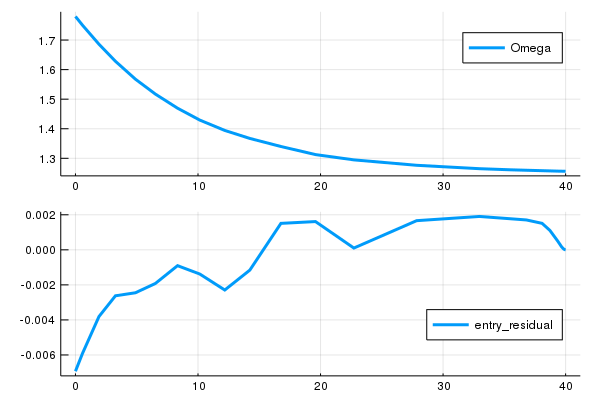

In [46]:
solved = solved.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3, legend = :bottomright)
plot(plot_Ω, plot_residual, layout = (2,1))

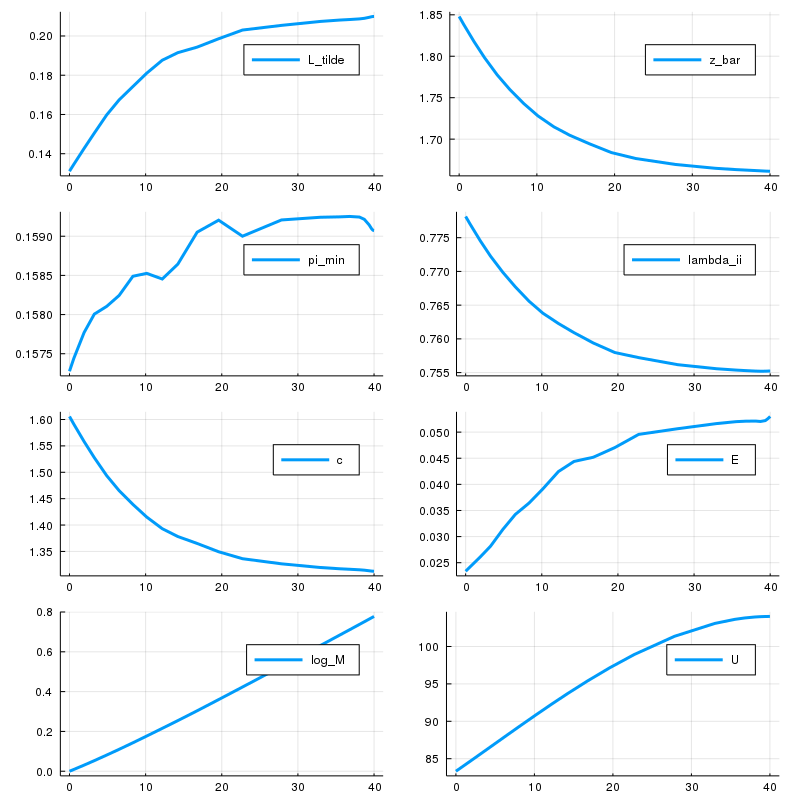

In [47]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2), size = (800, 800))

### Continuation Approach

The cell below takes a while to run, but is a relatively robust way to get the solution. 

In [23]:
#=    solve_continuation(3.07, # d_0 value
                        2.5019, # d_T value
                        step = 0.001, # default is 0.005 
                        params = parameter_defaults(), 
                        settings = settings_defaults(),
                        solver = solve_full_model_newuoa) # default is solve_full_model_python
=#